# Week V: image classification and OCR

In this week's lesson we're going to begin exploring the field of computer vision, and see how deep learning can help us solve problems in this field. We'll begin by building a neural network for image classification. We'll examine convolutional vs. fully-connected architectures, and see the adverse effect of noise on DL models.

## MNIST Dataset

The MNIST dataset is one of the most common datasets for image classifcation. It contains 70,000 samples of handwritten digits ranging from 0 to 9. The goal is to correctly recognize the handwritten digit. Here are a few examples taken from the original database:
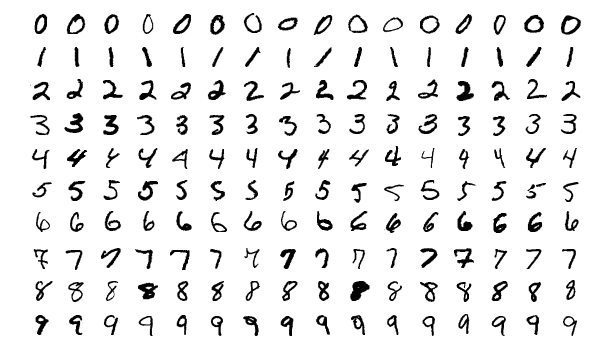

Let's begin by getting the data, using Keras. Keras already split the data into train vs. test and samples vs. labels for us:

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We'll continue by exploring the data.

In [ ]:
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)

Shape of x_train is: (60000, 28, 28)
Shape of y_train is: (60000,)
Shape of x_test is: (10000, 28, 28)
Shape of y_test is: (10000,)


We can see that each sample is an image of size 28X28 pixels.

In [ ]:
import numpy as np
np.min(x_train), np.max(x_train), x_train.dtype

(0, 255, dtype('uint8'))

Each pixel has integer values ranging from 0 to 255.

In [ ]:
np.min(y_train), np.max(y_train), y_train.dtype

(0, 9, dtype('uint8'))

Similarly, there are 10 labels (classes) in the dataset, represented by the integers 0-9. 

Let's plot some random samples with their labels:  

<Figure size 432x288 with 0 Axes>

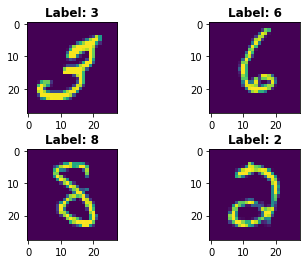

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_samples(x, y):
  plt.figure()

  f, axarr = plt.subplots(2, 2, gridspec_kw={'hspace':0.4}) 
  rands = np.random.randint(x.shape[0], size=4)
  axarr[0, 0].imshow(x[rands[0], :, :])
  axarr[0, 0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')

  axarr[1, 0].imshow(x[rands[1], :, :])
  axarr[1, 0].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')

  axarr[0, 1].imshow(x[rands[2], :, :])
  axarr[0, 1].set_title('Label: ' + str(y[rands[2]]), fontweight='bold')

  axarr[1, 1].imshow(x[rands[3], :, :])
  axarr[1, 1].set_title('Label: ' + str(y[rands[3]]), fontweight='bold')

  plt.show()

plot_random_samples(x_train, y_train)

Image data should often be scaled in some way to improve the convergence of the neural network. The two most common ways are to normalize the data to a Gaussian distribution, or to normalize it by dividing the data with the maximal value. We'll be using the latter method:

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Note that both training and testing sets must be normalized in the same way!

Let's check how the normalization changed the data:

In [ ]:
np.min(x_train), np.max(x_train), x_train.dtype

(0.0, 1.0, dtype('float64'))

We see that the min value stayed 0, while the max value is now 1. Also, the data is now of type 'float' and not 'int'.

We'll plot some samples again to make sure the shape of the images in the data did not change:

<Figure size 432x288 with 0 Axes>

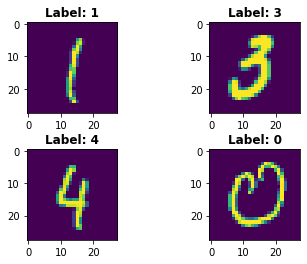

In [ ]:
plot_random_samples(x_train, y_train)

Finally, we'll split the training data into training vs validation:

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/6)

We chose 1/6 as the split ratio to keep the valdiation and testing sets the same size. After this split we should have 50k training samples, 10k testing, and 10 k validation: 

In [ ]:
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)
print('Shape of x_val is:', x_val.shape)
print('Shape of y_val is:', y_val.shape)

Shape of x_train is: (50000, 28, 28)
Shape of y_train is: (50000,)
Shape of x_test is: (10000, 28, 28)
Shape of y_test is: (10000,)
Shape of x_val is: (10000, 28, 28)
Shape of y_val is: (10000,)


We'll also change the labels to a one-hot format, such that each label is a sparse vector representing the correct class:

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

And their new shape should be (#num of samples, 10):

In [ ]:
print('Shape of y_train is:', y_train.shape)
print('Shape of y_test is:', y_test.shape)
print('Shape of y_val is:', y_val.shape)
print(y_train[0, :])

Shape of y_train is: (50000, 10)
Shape of y_test is: (10000, 10)
Shape of y_val is: (10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Finally, an image neural network expects a channel dimension. In our case we're dealing with a grayscale so the channel does not have a physical interpretation. We'll artificially increse the dimensions of the X-datasets:

In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
print('Shape of x_train is:', x_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of x_val is:', x_val.shape)

Shape of x_train is: (50000, 28, 28, 1)
Shape of x_test is: (10000, 28, 28, 1)
Shape of x_val is: (10000, 28, 28, 1)


## Building a neural network

Now that we've finished the preprocessing phase, we can move along and begin designing a neural network. We'll start with a very simple shallow fully-connected architecture.

We'll use the Keras Sequential API:


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()

We'll begin with an input layer that flattens every image. Since this is the first layer in a Sequential model, we must specify the input shape:

In [ ]:
model.add(Flatten(input_shape=(28, 28, 1)))

We'll add a single fully-connected hidden layer with 128 neurons and a ReLU activation:

In [ ]:
model.add(Dense(128, activation='relu'))

We'll finish the architecture with a final output (or prediction) layer. Since we have 10 different classes, we want the output of the network to be a vector of size 10 with the probabilities of each class. Hence, softmax is the fitting choice for activation:

In [ ]:
model.add(Dense(10, activation='softmax'))

This is our model:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Since this is a classification proble, we'll use the cross entropy (NLL) loss:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=16, epochs=10)

Epoch 1/10
3125/3125 [==============================] - 23s 7ms/step - loss: 0.2447 - accuracy: 0.9286 - val_loss: 0.1500 - val_accuracy: 0.9545
Epoch 2/10
3125/3125 [==============================] - 18s 6ms/step - loss: 0.1061 - accuracy: 0.9676 - val_loss: 0.1063 - val_accuracy: 0.9672
Epoch 3/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0710 - accuracy: 0.9785 - val_loss: 0.1023 - val_accuracy: 0.9693
Epoch 4/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0525 - accuracy: 0.9829 - val_loss: 0.0924 - val_accuracy: 0.9730
Epoch 5/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0390 - accuracy: 0.9873 - val_loss: 0.0960 - val_accuracy: 0.9718
Epoch 6/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.0310 - accuracy: 0.9899 - val_loss: 0.0881 - val_accuracy: 0.9745
Epoch 7/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0234 - accuracy: 0.9929 - val_loss: 0.0955 - val_ac

## Testing the model

Let's run the model on the testing data:

In [ ]:
y_pred = model.predict(x_test)

Each output is a vector of size 10: 

In [ ]:
y_pred.shape

(10000, 10)

Let's look at the larget value for each sample (the predicted class):

In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

And now we can compute the model's confusion matrix:

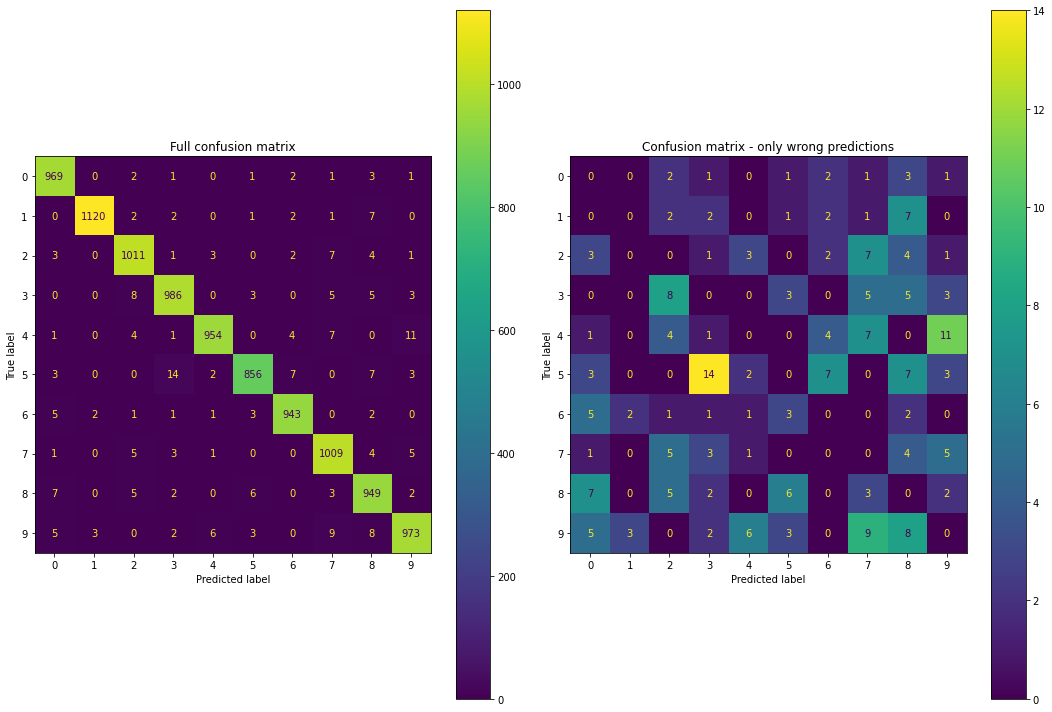

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

martix = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(martix).plot(ax=axes[0])
axes[0].title.set_text('Full confusion matrix')

np.fill_diagonal(martix, 0)
ConfusionMatrixDisplay(martix).plot(ax=axes[1])
axes[1].title.set_text('Confusion matrix - only wrong predictions')

plt.tight_layout()  
plt.show()

As you can see, most values are centered around the main diagonal which means our model performed well. Let's look at the accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels))

Accuracy:  0.977


For the sake of reference, random forest achieves an accuracy of around 0.972 after extensive hyper-parameter tuning.

We can also check the area under the receiver operating characteristic Curve (ROC AUC). Note that this is a multi-class classification problem, so we need to use averaging techniques:

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred, multi_class="ovo", average="macro")

0.9996260434027178

Finally, let's plot some of our predictions. Note that we'll need to remove the channels dimension for the plot to work:

<Figure size 432x288 with 0 Axes>

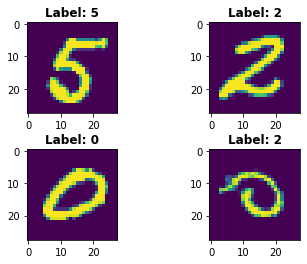

In [ ]:
plot_random_samples(x_test[:, :, :, 0], y_pred_labels)

## Adding noise

In real life, we often get noisy images. This is true for data in general, but noise has been studied extensively in the field of image processing. By adding noise to our previous problem we can greatly increase its difficulty.

### Noise: 50% 

Let's add Gaussian noise at the 50% level:

In [ ]:
np.random.seed(42)
x_train_noisy = x_train + 0.5 * np.random.randn(*x_train.shape) 
x_val_noisy = x_val + 0.5 * np.random.randn(*x_val.shape) 
x_test_noisy = x_test + 0.5 * np.random.randn(*x_test.shape) 

And view some samples:

<Figure size 432x288 with 0 Axes>

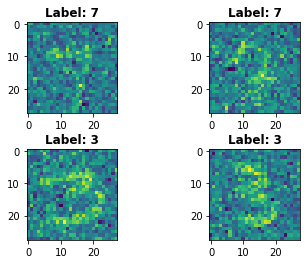

In [ ]:
plot_random_samples(x_test_noisy[:, :, :, 0], y_true_labels)

Clearly, the numerals are far less identifiable now. Let's see how are model behaves:

In [ ]:
y_pred_noisy = model.predict(x_test_noisy)

In [ ]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [ ]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.7115


Indeed, we observe a drop in accuracy. It's understandable, since our network did not see any noisy images. Let's try to retrain the model on the noisy data:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train_noisy, y_train, validation_data=(x_val_noisy, y_val), batch_size=16, epochs=10)

Epoch 1/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.6122 - accuracy: 0.8654 - val_loss: 0.4294 - val_accuracy: 0.8840
Epoch 2/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.1734 - accuracy: 0.9484 - val_loss: 0.4016 - val_accuracy: 0.8961
Epoch 3/10
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0708 - accuracy: 0.9771 - val_loss: 0.4144 - val_accuracy: 0.9016
Epoch 4/10
3125/3125 [==============================] - 11s 4ms/step - loss: 0.0311 - accuracy: 0.9914 - val_loss: 0.4420 - val_accuracy: 0.9025
Epoch 5/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.4645 - val_accuracy: 0.9044
Epoch 6/10
3125/3125 [==============================] - 11s 4ms/step - loss: 0.0156 - accuracy: 0.9956 - val_loss: 0.5223 - val_accuracy: 0.9068
Epoch 7/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.0122 - accuracy: 0.9963 - val_loss: 0.5549 - val_ac

In [ ]:
y_pred_noisy = model.predict(x_test_noisy)

In [ ]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [ ]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.9092


And the results greatly improved.

### Noise: 100% 

Let's add even more noise:

In [ ]:
np.random.seed(42)
x_train_noisy = x_train + 1 * np.random.randn(*x_train.shape) 
x_val_noisy = x_val + 1 * np.random.randn(*x_val.shape) 
x_test_noisy = x_test + 1 * np.random.randn(*x_test.shape) 

<Figure size 432x288 with 0 Axes>

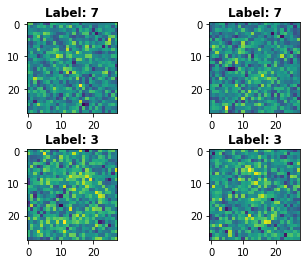

In [ ]:
plot_random_samples(x_test_noisy[:, :, :, 0], y_true_labels)

The numerals are barely recognizable at this point.

In [ ]:
y_pred_noisy = model.predict(x_test_noisy)

In [ ]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [ ]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.6663


And our model does not perform well at all. Let's retrain it on the new noisy data:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train_noisy, y_train, validation_data=(x_val_noisy, y_val), batch_size=16, epochs=10)

Epoch 1/10
3125/3125 [==============================] - 12s 4ms/step - loss: 1.2739 - accuracy: 0.8104 - val_loss: 2.5002 - val_accuracy: 0.7170
Epoch 2/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.3264 - accuracy: 0.9122 - val_loss: 2.4425 - val_accuracy: 0.7215
Epoch 3/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.1431 - accuracy: 0.9530 - val_loss: 2.4733 - val_accuracy: 0.7222
Epoch 4/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.1089 - accuracy: 0.9632 - val_loss: 2.4896 - val_accuracy: 0.7260
Epoch 5/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0847 - accuracy: 0.9710 - val_loss: 2.6019 - val_accuracy: 0.7239
Epoch 6/10
3125/3125 [==============================] - 11s 4ms/step - loss: 0.0738 - accuracy: 0.9755 - val_loss: 2.6341 - val_accuracy: 0.7237
Epoch 7/10
3125/3125 [==============================] - 11s 4ms/step - loss: 0.0685 - accuracy: 0.9768 - val_loss: 2.7809 - val_ac

In [ ]:
y_pred_noisy = model.predict(x_test_noisy)

In [ ]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [ ]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.7355


We see an improvement, but the accuracy is still quite bad.

### Convolutional neural network

Nowadays, practically all computer vision neural networks utilize convolutions. CNNs have the advantage of correctly identifying spatial connections and giving them extra significance. FC networks do not have this property. 

Let's build a CNN for our 100% noise problem:

In [ ]:
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout

conv_model = Sequential()
conv_model.add(Input(shape=(28, 28, 1)))
conv_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Flatten())
conv_model.add(Dropout(0.5))
conv_model.add(Dense(10, activation="softmax"))

We have two convolutional layers and two max pooling layers. In the end we flatten the hidden layers' output and feed it into a final FC output layer.

In [ ]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)             

In [ ]:
conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
conv_model.fit(x_train_noisy, y_train, validation_data=(x_val_noisy, y_val), batch_size=16, epochs=10)

Epoch 1/10
3125/3125 [==============================] - 18s 5ms/step - loss: 0.9165 - accuracy: 0.6912 - val_loss: 0.6056 - val_accuracy: 0.8030
Epoch 2/10
3125/3125 [==============================] - 17s 5ms/step - loss: 0.7108 - accuracy: 0.7633 - val_loss: 0.5791 - val_accuracy: 0.8090
Epoch 3/10
3125/3125 [==============================] - 17s 6ms/step - loss: 0.6866 - accuracy: 0.7697 - val_loss: 0.5652 - val_accuracy: 0.8156
Epoch 4/10
3125/3125 [==============================] - 17s 5ms/step - loss: 0.6745 - accuracy: 0.7748 - val_loss: 0.5530 - val_accuracy: 0.8176
Epoch 5/10
3125/3125 [==============================] - 16s 5ms/step - loss: 0.6663 - accuracy: 0.7763 - val_loss: 0.5670 - val_accuracy: 0.8127
Epoch 6/10
3125/3125 [==============================] - 16s 5ms/step - loss: 0.6544 - accuracy: 0.7822 - val_loss: 0.5374 - val_accuracy: 0.8246
Epoch 7/10
3125/3125 [==============================] - 16s 5ms/step - loss: 0.6450 - accuracy: 0.7842 - val_loss: 0.5371 - val_ac

In [ ]:
y_pred_noisy = conv_model.predict(x_test_noisy)

In [ ]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [ ]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.8364


In [ ]:
def plot_random_samples_with_noise(x, x_noisy, y, y_pred):
  %matplotlib inline

  f, axarr = plt.subplots(4, 2, gridspec_kw={'hspace':0.4}, figsize=(18, 12), constrained_layout=True) 
  rands = np.random.randint(x.shape[0], size=4)

  axarr[0, 0].imshow(x[rands[0], :, :])
  axarr[0, 0].set_title('lRea label: ' + str(y[rands[0]]), fontweight='bold')
  axarr[0, 1].imshow(x_noisy[rands[0], :, :])
  axarr[0, 1].set_title('Predicted label: ' + str(y_pred[rands[0]]), fontweight='bold')

  axarr[1, 0].imshow(x[rands[1], :, :])
  axarr[1, 0].set_title('Real label: ' + str(y[rands[1]]), fontweight='bold')
  axarr[1, 1].imshow(x_noisy[rands[1], :, :])
  axarr[1, 1].set_title('Label: ' + str(y_pred[rands[1]]), fontweight='bold')

  axarr[2, 0].imshow(x[rands[2], :, :])
  axarr[2, 0].set_title('Real label: ' + str(y[rands[2]]), fontweight='bold')
  axarr[2, 1].imshow(x_noisy[rands[2], :, :])
  axarr[2, 1].set_title('Predicted label: ' + str(y_pred[rands[2]]), fontweight='bold')

  axarr[3, 0].imshow(x[rands[3], :, :])
  axarr[3, 0].set_title('Real label: ' + str(y[rands[3]]), fontweight='bold')
  axarr[3, 1].imshow(x_noisy[rands[3], :, :])
  axarr[3, 1].set_title('Predicted label: ' + str(y_pred[rands[3]]), fontweight='bold')

  plt.show()

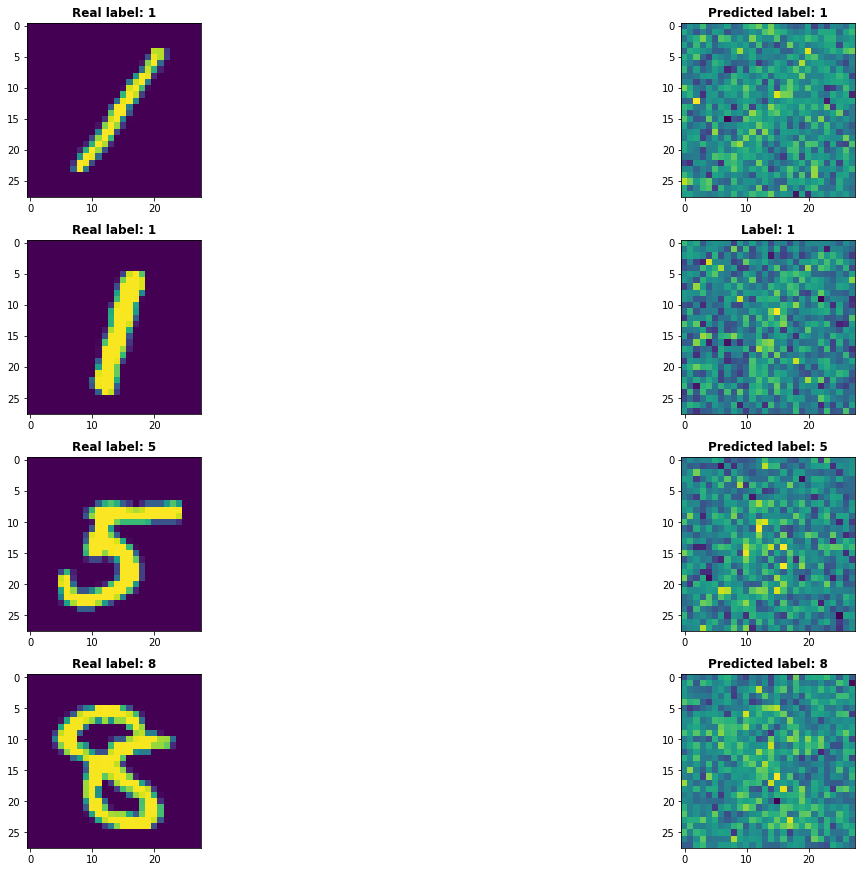

In [ ]:
plot_random_samples_with_noise(x_test[:, :, :, 0], x_test_noisy[:, :, :, 0], y_true_labels, y_pred_labels_noisy)

### Predefined architecture

We'll use [Keras applications](https://keras.io/api/applications/) to load predefined models.

In [ ]:
import tensorflow as tf

In [ ]:
x_train_noisy.shape

(50000, 28, 28, 1)

Switch to RGB:

In [ ]:
x_train_noisy_rgb = np.repeat(x_train_noisy, 3, axis=-1)
x_val_noisy_rgb = np.repeat(x_val_noisy, 3, axis=-1)
x_test_noisy_rgb = np.repeat(x_test_noisy, 3, axis=-1)
x_train_noisy_rgb.shape

(50000, 28, 28, 3)

Increase size to 32X32 to enable the model to run smoothly:

In [ ]:
x_train_noisy_rgb = tf.image.resize(x_train_noisy_rgb, [32, 32])
x_val_noisy_rgb = tf.image.resize(x_val_noisy_rgb, [32, 32])
x_test_noisy_rgb = tf.image.resize(x_test_noisy_rgb, [32, 32])
x_train_noisy_rgb.shape

TensorShape([50000, 32, 32, 3])

Use the predefined ResNet model:

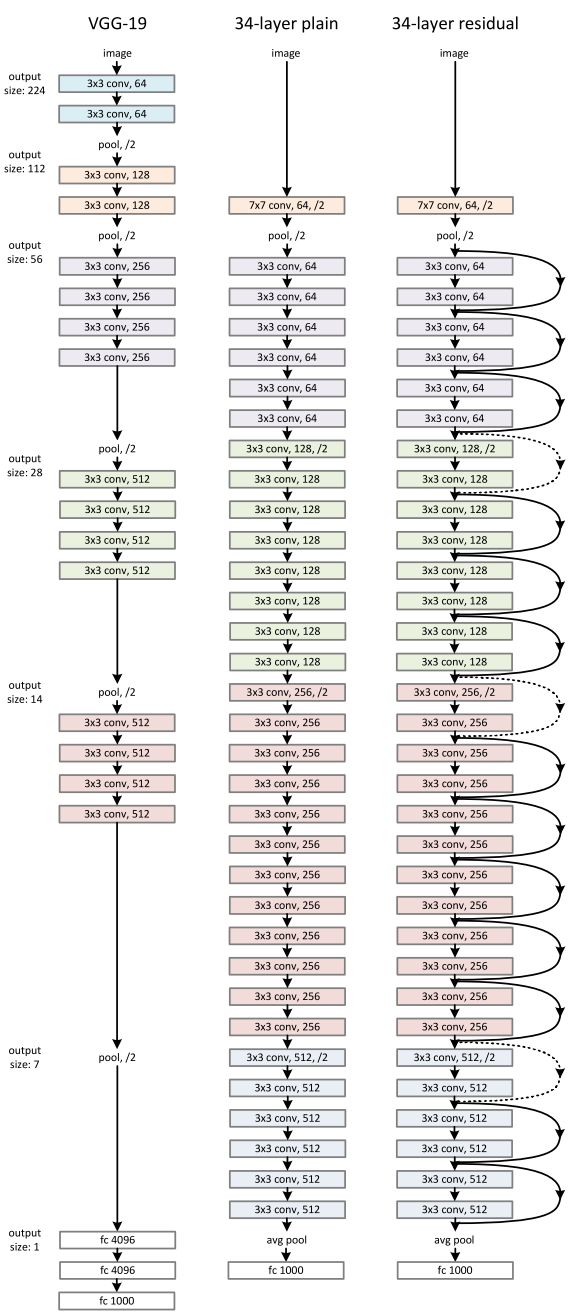

In [ ]:
input = tf.keras.Input(shape=(32, 32, 3))
resnet = tf.keras.applications.ResNet50V2(weights=None,
                                          include_top=False, 
                                          input_tensor=input)

mid = tf.keras.layers.GlobalMaxPooling2D()(resnet.output)

output = tf.keras.layers.Dense(10, activation='softmax')(mid)

resnet_model = tf.keras.Model(resnet.input, output)

In [ ]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

In [ ]:
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_model.fit(x_train_noisy_rgb, y_train, validation_data=(x_val_noisy_rgb, y_val), batch_size=16, epochs=10)

Epoch 1/10
3125/3125 [==============================] - 287s 89ms/step - loss: 1.1303 - accuracy: 0.6554 - val_loss: 0.9988 - val_accuracy: 0.6772
Epoch 2/10
3125/3125 [==============================] - 277s 89ms/step - loss: 0.7616 - accuracy: 0.7638 - val_loss: 0.6696 - val_accuracy: 0.8025
Epoch 3/10
3125/3125 [==============================] - 266s 85ms/step - loss: 0.6940 - accuracy: 0.7829 - val_loss: 0.6838 - val_accuracy: 0.7784
Epoch 4/10
3125/3125 [==============================] - 266s 85ms/step - loss: 0.6087 - accuracy: 0.8059 - val_loss: 0.6302 - val_accuracy: 0.7921
Epoch 5/10
3125/3125 [==============================] - 267s 85ms/step - loss: 0.5255 - accuracy: 0.8320 - val_loss: 0.6046 - val_accuracy: 0.7996
Epoch 6/10
3125/3125 [==============================] - 275s 88ms/step - loss: 0.4747 - accuracy: 0.8467 - val_loss: 0.4943 - val_accuracy: 0.8419
Epoch 7/10
3125/3125 [==============================] - 265s 85ms/step - loss: 0.4249 - accuracy: 0.8626 - val_loss: 0

In [ ]:
y_pred_noisy = resnet_model.predict(x_test_noisy_rgb)

In [ ]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [ ]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.849


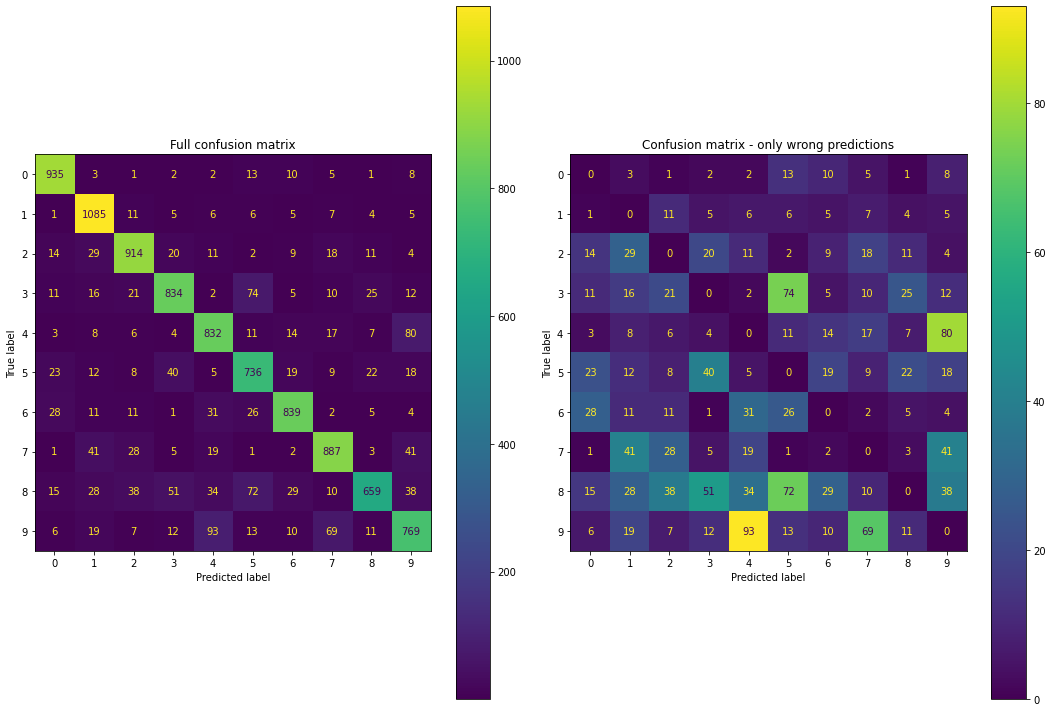

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

martix = confusion_matrix(y_true_labels, y_pred_labels_noisy)
ConfusionMatrixDisplay(martix).plot(ax=axes[0])
axes[0].title.set_text('Full confusion matrix')

np.fill_diagonal(martix, 0)
ConfusionMatrixDisplay(martix).plot(ax=axes[1])
axes[1].title.set_text('Confusion matrix - only wrong predictions')

plt.tight_layout()  
plt.show()

## Random Forest

In [ ]:
x_train_noisy.shape, x_test_noisy.shape

((50000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
x_train_rf = np.zeros((x_train.shape[0], int(x_train.shape[1]**2)))
x_test_rf = np.zeros((x_test.shape[0], int(x_test.shape[1]**2)))

x_train_rf.shape, x_test_rf.shape

((50000, 784), (10000, 784))

In [ ]:
for i in range(x_test_rf.shape[0]):
  x_test_rf[i, :] = x_test_noisy[i, :, :, 0].flatten()

In [ ]:
for i in range(x_train_rf.shape[0]):
  x_train_rf[i, :] = x_train_noisy[i, :, :, 0].flatten()

In [ ]:
x_train_rf[0, :].shape

(784,)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42, 
                                n_jobs=-1, 
                                max_features=1/3)
rf_clf.fit(x_train_rf, np.argmax(y_train, axis=1))

RandomForestClassifier(max_features=0.3333333333333333, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred_rf = rf_clf.predict(x_test_rf)

In [ ]:
accuracy_score(np.argmax(y_test, axis=1), y_pred_rf)

0.4544

## Final thoughts

In today's demonstartion we saw how an exremely simple neural network can solve a somewhat complex problem. Without any hyperparemeter-tuning or complex covolutional architectures we managed to outperform classical ML methods. This is the power of neural networks.

We saw how noise can make a problem much more difficult. We saw how convolutions can capture spatial dependencies much better than FC. We also showed that random forest and tree-based algorithm perform rather poorly on images. Finally, we learned how to load a pre-defined model and re-train it.

Next week, we're going to cover even more complex problems in the domain of computer vision.